In [1]:
import pandas as pd
import numpy as np
import re
from itertools import compress
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

## Loading data

Load the data from tran and test CSV files. After, loading, concat the two dataframes into one to make some _feature engineering_.

In [2]:
# For .read_csv, always use header=0 when you know row 0 is the header row
train = pd.read_csv('/home/ds/notebooks/titanic/train.csv', header=0, index_col="PassengerId")
test = pd.read_csv('/home/ds/notebooks/titanic/test.csv', header=0, index_col="PassengerId")

# Merge the data frame 
full = pd.concat([train, test])


## Feature engineering

Next step is to play with the features, try to normalize data and create some new features, based on the existing.


### Extract title

The name is the combination of last name, the title and the person name. Using regular expression, the Title is extracted and a new column is created with this new information.

In [3]:
# The name pattern
pattern = '(.*, )|(\\..*)'

# Apply the pattern
titles = [re.sub(pattern, "", elem) for elem in full['Name']]

# Create the new column with the new feature
full['Title'] = titles

Some titles are the same, but written in different ways, like Mlle, Ms and Miss or Mme and Mrs. Let's normalize them:

In [4]:
# Normalize some titles
full.loc[full['Title'] == 'Mlle', 'Title'] = 'Miss'
full.loc[full['Title'] == 'Ms', 'Title'] = 'Miss'
full.loc[full['Title'] == 'Mme', 'Title'] = 'Mrs'


Some titles we can consider as _rare_, like Dona, Lady, the Countness, Capt, Col, Don, Dr, Major, Rev, Sir or Jonkheer. We will find the passengers with these titles and replace to _Rare Title_:

In [5]:
rare_titles = ('Dona', 'Lady', 'the Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer')

full.loc[full['Title'].isin(rare_titles), 'Title'] = 'Rare Title'

### Family name

Let's find the people family name and create a new feature for that, then we can group people with same surname and see if they were rescued.

In [6]:
# Split the name and get the first piece to create the surname column
surnames = [name.split(',', 1)[0] for name in full['Name']]
full['Surname'] = surnames

### Family size

The family size is the sum of siblings/spouses and parents/childern plus themselves. To create the families, get the surname and concat with the family size.


In [7]:
# Sum the number of siblings/spouses , parents/children and themselves
full['Fsize'] = full['SibSp'] + full['Parch'] + 1

# Concat the family name with the number of people
families = full.apply(lambda line: line['Surname']+ "_"+ str(line['Fsize']), axis=1)

# Create the new feature
full['Family'] = families


Next step is to categorize the family in small, large or if you are single. Let's consider families with more than 4 people large.

In [8]:
full.loc[full['Fsize'] < 5, 'FsizeD'] = 'small'
full.loc[full['Fsize'] > 4, 'FsizeD'] = 'large'
full.loc[full['Fsize'] == 1, 'FsizeD'] = 'singleton'

## Missing data

Some fields are not properly filled. Let's explore the data frame and try to find and fill this missing data.

### Exploring the data set

Let's check if there are any `null` values in the `full` dataframe:

In [9]:
full.isnull().values.any()

True

In [10]:
colNames = list(full.columns.values)

# This lambda will get all columns with null values
colWithNull =[(lambda col: full[col].isnull().values.any())(col) for col in colNames]

list(compress(colNames, colWithNull))

['Age', 'Cabin', 'Embarked', 'Fare', 'Survived']

We have five columns with missing data, *Age*, *Cabin*, *Embarked*, *Fare* and *Survived*. The last one, we know that have _null_ values because we put together train and test datasets. But we can explore the other four features to see if we can work to infer the values.

#### Feature 'Embarked'

Let's see with rows have missing data for the *Embarked* feature:

In [11]:
featureWithNull = full['Embarked'].isnull()

featureWithNullIndex = [(i+1) for i, x in enumerate(featureWithNull) if x]
featureWithNullIndex

[62, 830]

Passengers index 62 and 830 does not have the _Embarked_ feature, let's see how do they look:

In [12]:
full.ix[featureWithNullIndex]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title,Surname,Fsize,Family,FsizeD
PassengerId,,,,,,,,,,,,,,,,
62,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,1,female,0,1.0,113572,Miss,Icard,1,Icard_1,singleton
830,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,1,female,0,1.0,113572,Mrs,Stone,1,Stone_1,singleton


We can see that the passengers were two woman, paid $80 for class 1 and were single. Let's explore the dataframe and see if there are data with the same values.

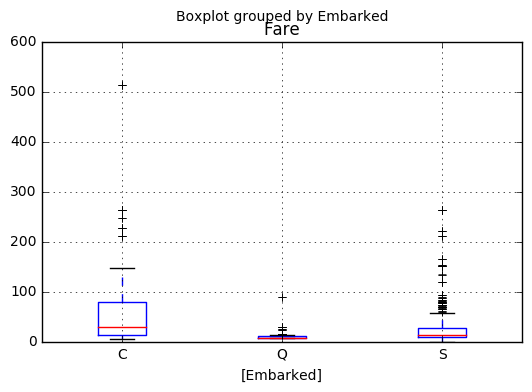

In [13]:
# Select only the data we want (Pclass, Embarked, Fare)
data_to_plot = full[["Embarked", "Fare"]]

data_to_plot.boxplot(by="Embarked")

We can see in the graph that the chance that passengers paying $80 embarked on gate C, so let's change the values for them.

In [14]:
full.loc[featureWithNullIndex, 'Embarked'] = 'C'
full.loc[featureWithNullIndex]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title,Surname,Fsize,Family,FsizeD
PassengerId,,,,,,,,,,,,,,,,
62,38.0,B28,C,80.0,"Icard, Miss. Amelie",0,1,female,0,1.0,113572,Miss,Icard,1,Icard_1,singleton
830,62.0,B28,C,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,1,female,0,1.0,113572,Mrs,Stone,1,Stone_1,singleton


In [15]:
full['Embarked'].isnull().values.any()

False

#### Feature 'Fare'

Let's see with rows have missing data for the *Fare* feature:

In [16]:
featureWithNull = full['Fare'].isnull()

featureWithNullIndex = [(i + 1) for i, x in enumerate(featureWithNull) if x]
featureWithNullIndex

[1044]

Only passenger 1044 has no values, let's see it:

In [17]:
full.loc[featureWithNullIndex]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title,Surname,Fsize,Family,FsizeD
PassengerId,,,,,,,,,,,,,,,,
1044,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,3,male,0,NaN,3701,Mr,Storey,1,Storey_1,singleton


This passenger is a single man from class 3 and embarked on Southampton (Embarked = 'S'). Let's check passengers with same features.

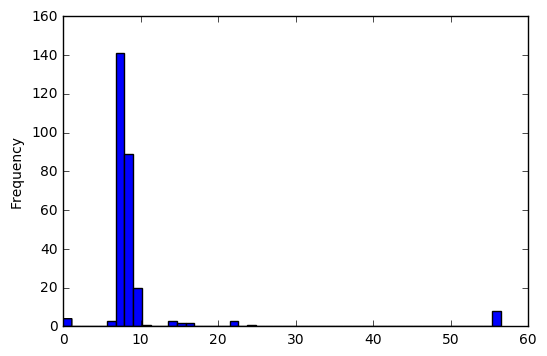

In [18]:
data_to_plot = full[(full["Pclass"] == 3) & (full["Embarked"] == 'S') & (full["Fsize"] == 1) & (full["Sex"] == "male")]

data_to_plot["Fare"].plot.hist(bins=50)

We can see that most people paid around \$10 to get in. If we take the mean, the value will be around \$10, so let's use it as the value. 

In [19]:
m = data_to_plot['Fare'].mean().item()
full.loc[featureWithNullIndex, 'Fare'] = m
full.loc[featureWithNullIndex]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title,Surname,Fsize,Family,FsizeD
PassengerId,,,,,,,,,,,,,,,,
1044,60.5,NaN,S,9.654567,"Storey, Mr. Thomas",0,3,male,0,NaN,3701,Mr,Storey,1,Storey_1,singleton


### Feature 'age'

We have some passengers withou age:

In [20]:
featureWithNull = full['Age'].isnull()

featureWithNullIndex = [(i + 1) for i, x in enumerate(featureWithNull) if x]
featureWithNullIndex

[6,
 18,
 20,
 27,
 29,
 30,
 32,
 33,
 37,
 43,
 46,
 47,
 48,
 49,
 56,
 65,
 66,
 77,
 78,
 83,
 88,
 96,
 102,
 108,
 110,
 122,
 127,
 129,
 141,
 155,
 159,
 160,
 167,
 169,
 177,
 181,
 182,
 186,
 187,
 197,
 199,
 202,
 215,
 224,
 230,
 236,
 241,
 242,
 251,
 257,
 261,
 265,
 271,
 275,
 278,
 285,
 296,
 299,
 301,
 302,
 304,
 305,
 307,
 325,
 331,
 335,
 336,
 348,
 352,
 355,
 359,
 360,
 365,
 368,
 369,
 376,
 385,
 389,
 410,
 411,
 412,
 414,
 416,
 421,
 426,
 429,
 432,
 445,
 452,
 455,
 458,
 460,
 465,
 467,
 469,
 471,
 476,
 482,
 486,
 491,
 496,
 498,
 503,
 508,
 512,
 518,
 523,
 525,
 528,
 532,
 534,
 539,
 548,
 553,
 558,
 561,
 564,
 565,
 569,
 574,
 579,
 585,
 590,
 594,
 597,
 599,
 602,
 603,
 612,
 613,
 614,
 630,
 634,
 640,
 644,
 649,
 651,
 654,
 657,
 668,
 670,
 675,
 681,
 693,
 698,
 710,
 712,
 719,
 728,
 733,
 739,
 740,
 741,
 761,
 767,
 769,
 774,
 777,
 779,
 784,
 791,
 793,
 794,
 816,
 826,
 827,
 829,
 833,
 838,
 840,
 84

In [21]:
len(featureWithNullIndex)

263

We have `263` passengers with missing age. We will try to use _Random Forrest_ to predict the passenger age based on some fields.

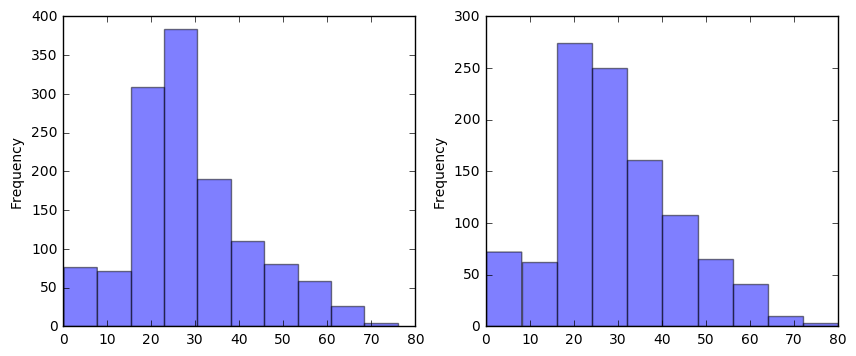

In [22]:
# Get all columns
colNames = list(full.columns.values)

# and removed some we don't want to use
notInList = list(['PassengerId','Name','Ticket','Cabin','Family','Surname','Survived', 'Age'])
cols = list(set(colNames) - set(notInList))

# Get the values that has age to create the model
featureWithNull = full['Age'].notnull()

trainData = pd.get_dummies(full.loc[featureWithNull, cols])
targetData = list(full.loc[featureWithNull, 'Age'] * 100)

featureWithNull = full['Age'].isnull()

testData = pd.get_dummies(full[cols])

# Create the random forest object which will include all the parameters
# for the fit
forest = RandomForestClassifier(n_estimators = 100)

# Fit the training data to the Survived labels and create the decision trees
forest = forest.fit(trainData, targetData)

# Predict the values
output = forest.predict(testData)
output = list(output / 100)

# Add new column, so we cam compare the results
full['NewAge'] = output

# Plot the histograms side by side
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

full['NewAge'].plot.hist(alpha=0.5, ax=axs[0])
full['Age'].plot.hist(alpha=0.5, ax=axs[1])

# Set the age with new age and remove the column 
full['Age'] = full['NewAge']
del full['NewAge']

We can see the predict worked fine. Now we can full fill the age columns with the predicted values and remove the 'NewAge' column.

### Feature 'cabin'

We have some passengers withou cabin:

In [23]:
featureWithNull = full['Cabin'].isnull()

featureWithNullIndex = [(i + 1) for i, x in enumerate(featureWithNull) if x]
len(featureWithNullIndex)

1014

We have more than 1000 passengers without Cabin. Is it hard to predict with cabin the passenger was with a lot of missing values. So we will keep this feature with empty values.

## Feature Engineering

Now that we have completed some missing values, is it time to see if we can create new features for our data frame.

### Mothers

A mother is a female person, with more than 18 years, has children and does not have the title 'Miss':

In [24]:
# By default, everybody is not a mother
full['Mother'] = 'Not Mother'

# Then, set the mothers,
full.loc[(full["Sex"] == 'female') & (full["Parch"] > 0) & (full["Title"] != 'Miss'), 'Mother'] = 'Mother'

In [25]:
pd.crosstab(full["Mother"],full["Survived"],margins=True)

Survived,0.0,1.0,All
Mother,,,
Mother,16,40,56
Not Mother,533,302,835
All,549,342,891


## Prediction

Now that we have our fileds OK, is it time to predict who was saved. Let's split the dataframe in the `train` and `test` again:


In [26]:
train = full[:891]
test = full[891:]

The list of features we want to use to predict is: Pclass + Sex + Age + SibSp + Parch + Fare + Embarked + Title + FsizeD + Child + Mother

In [27]:
cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'FsizeD', 'Mother']

trainData = pd.get_dummies(train[cols])
targetData = train['Survived']

testData = pd.get_dummies(test[cols])
forest = RandomForestClassifier(n_estimators = 100)

# Fit the training data to the Survived labels and create the decision trees
forest = forest.fit(trainData, targetData)

# Predict the values
output = forest.predict(testData)


In [28]:
solution = pd.DataFrame({'Survived': output, 'PassengerId': test.index})
solution['Survived'] = solution['Survived'].astype(int)

solution.to_csv('pandas_titanic.csv', index=0)